In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-apr-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-apr-2022/train_labels.csv
/kaggle/input/tabular-playground-series-apr-2022/train.csv
/kaggle/input/tabular-playground-series-apr-2022/test.csv


In [2]:
trainDF=pd.read_csv("/kaggle/input/tabular-playground-series-apr-2022/train.csv")
trainDF.head()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359


In [3]:
trainDF_label=pd.read_csv("/kaggle/input/tabular-playground-series-apr-2022/train_labels.csv")
trainDF_label.head()

,sequence,state
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1


In [4]:
testDF=pd.read_csv("/kaggle/input/tabular-playground-series-apr-2022/test.csv")
testDF.head()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,25968,684,0,2.427357,19.639706,1.0,-1.466372,-1.289973,-4.207928,2.486339,-2.493893,8.0,-1.123555,-1.673048,10.980453,0.419011
1,25968,684,1,-4.950541,-21.747899,1.0,0.983186,-0.569053,1.845924,-3.887978,1.727481,-2.9,0.395231,-0.882233,-1.871399,-0.008525
2,25968,684,2,1.136012,-10.756303,1.0,1.016814,0.964157,2.454749,0.312386,1.154198,-5.6,1.114162,1.525273,-11.584362,0.139812
3,25968,684,3,0.806028,6.504202,1.0,-0.179646,0.969221,-1.035153,-0.457195,0.254962,-2.7,-0.588873,0.608761,-4.241770,-0.462916
4,25968,684,4,1.288253,5.552521,1.0,-0.493805,-1.036124,-1.126402,2.008197,-0.730534,0.0,0.899566,-1.259615,-0.472222,-0.121483


In [5]:
features = trainDF.columns.tolist()[3:]
features

['sensor_00',
 'sensor_01',
 'sensor_02',
 'sensor_03',
 'sensor_04',
 'sensor_05',
 'sensor_06',
 'sensor_07',
 'sensor_08',
 'sensor_09',
 'sensor_10',
 'sensor_11',
 'sensor_12']

进行一个非常特殊的预处理，先不做了！

In [6]:
def prep(df):
    for feature in features:
        #分组进行向下移动
        df[feature + '_lag1'] = df.groupby('sequence')[feature].shift(1)
        df.fillna(0, inplace=True)
        #求一个差值，好奇怪的操作
        df[feature + '_diff1'] = df[feature] - df[feature + '_lag1']    

prep(trainDF)
prep(testDF)

In [7]:
#标准化处理
from sklearn.preprocessing import StandardScaler
features = trainDF.columns.tolist()[3:]
sc = StandardScaler()
trainDF[features] = sc.fit_transform(trainDF[features])
testDF[features] = sc.transform(testDF[features])

In [8]:
groups = trainDF["sequence"]
labels = trainDF_label["state"]

In [9]:
#只获取values
trainDF = trainDF.drop(["sequence", "subject", "step"], axis=1).values
#转换为60个变量一组,60*13，一个变量包括60个list，一个list有13个数据
trainDF = trainDF.reshape(-1, 60, trainDF.shape[-1])


testDF = testDF.drop(["sequence", "subject", "step"], axis=1).values
testDF = testDF.reshape(-1, 60, trainDF.shape[-1])

In [10]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Concatenate, LSTM, GRU
from tensorflow.keras.layers import Bidirectional, Multiply

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import roc_auc_score

from sklearn.model_selection import KFold, GroupKFold

In [11]:
trainDF.shape

(25968, 60, 39)

In [12]:
def dnn_model():
    
    x_input = Input(shape=(trainDF.shape[-2:]))
    
    #每个层是什么意思，不清楚
    x1 = Bidirectional(LSTM(units=512, return_sequences=True))(x_input)
    x2 = Bidirectional(LSTM(units=256, return_sequences=True))(x1)
    z1 = Bidirectional(GRU(units=256, return_sequences=True))(x1)
    
    c = Concatenate(axis=2)([x2, z1])
    
    x3 = Bidirectional(LSTM(units=128, return_sequences=True))(c)
    
    x4 = GlobalMaxPooling1D()(x3)
    x5 = Dense(units=128, activation='selu')(x4)
    x_output = Dense(1, activation='sigmoid')(x5)

    model = Model(inputs=x_input, outputs=x_output, name='lstm_model')
    
    return model

model=dnn_model()

2022-04-07 03:50:59.002827: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [13]:
model.summary()

Model: "lstm_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 39)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 60, 1024)     2260992     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 60, 512)      2623488     bidirectional[0][0]              
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 60, 512)      1969152     bidirectional[0][0]              
_________________________________________________________________________________________

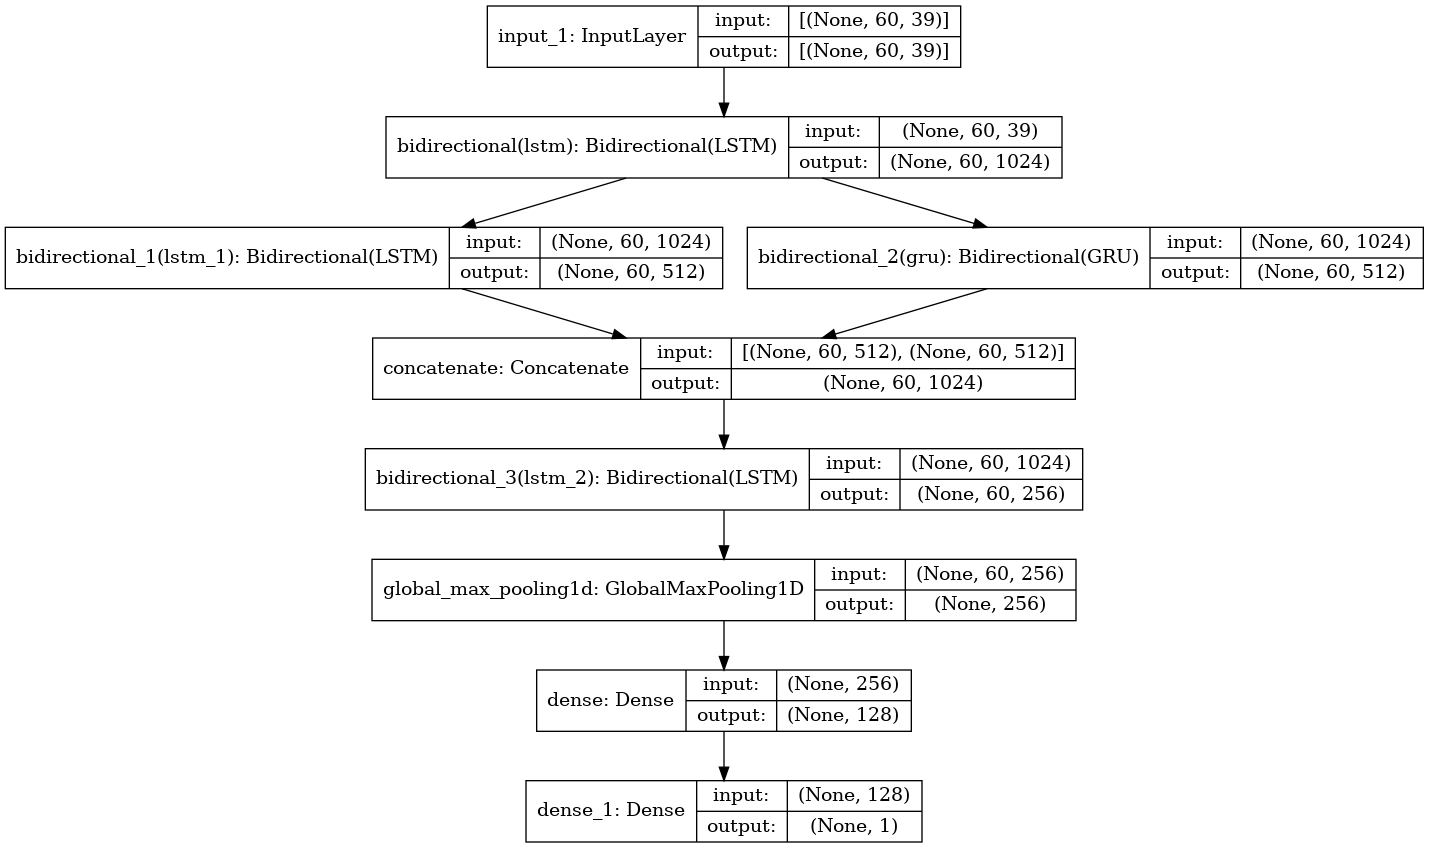

In [14]:
tf.keras.utils.plot_model(model, "temp.png", show_shapes=True)

In [15]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics='AUC')
lr = ReduceLROnPlateau(monitor="val_auc", factor=0.6, 
                               patience=4, verbose=1)
es = EarlyStopping(monitor="val_auc", patience=7, 
                           verbose=1, mode="max", 
                           restore_best_weights=True)

In [16]:
from random import randint, sample
sample_index=sample(range(len(labels)),round(len(labels)*0.7))

In [17]:
all_index=list(range(len(labels)))
val_index=list(set(all_index) - set(sample_index))

In [18]:
X_train, X_val = trainDF[sample_index], trainDF[val_index]
y_train, y_val = labels.iloc[sample_index].values, labels.iloc[val_index].values

In [19]:
history=model.fit(X_train, y_train, 
          validation_data=(X_val, y_val), 
          epochs=10,
          verbose=1,
          batch_size=64, 
          callbacks=[lr,es])

2022-04-07 03:51:02.647895: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
285/285 [==============================] - 742s 3s/step - loss: 0.5131 - auc: 0.8239 - val_loss: 0.4509 - val_auc: 0.8717
Epoch 2/10
285/285 [==============================] - 729s 3s/step - loss: 0.3703 - auc: 0.9145 - val_loss: 0.4309 - val_auc: 0.9181
Epoch 3/10
285/285 [==============================] - 740s 3s/step - loss: 0.3109 - auc: 0.9406 - val_loss: 0.4490 - val_auc: 0.9343
Epoch 4/10
285/285 [==============================] - 734s 3s/step - loss: 0.2989 - auc: 0.9453 - val_loss: 0.2965 - val_auc: 0.9479
Epoch 5/10
285/285 [==============================] - 739s 3s/step - loss: 0.2404 - auc: 0.9648 - val_loss: 0.3295 - val_auc: 0.9502

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
Epoch 6/10
285/285 [==============================] - 733s 3s/step - loss: 0.1856 - auc: 0.9789 - val_loss: 0.2728 - val_auc: 0.9585
Epoch 7/10
285/285 [==============================] - 729s 3s/step - loss: 0.1653 - auc: 0.9833 - val_loss: 0.2804 - val_

In [20]:
model.save("./tabularPlayground0406_01")

2022-04-07 05:53:16.321113: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


预测

In [21]:
 modelx=tf.keras.models.load_model('./tabularPlayground0406_01')

In [28]:
predictions=model.predict(testDF)

In [31]:
ssub = pd.read_csv('../input/tabular-playground-series-apr-2022/sample_submission.csv')
ssub["state"] =predictions
ssub.to_csv('submition.csv', index=False)

In [33]:
ssub.head()

,sequence,state
0,25968,9.994322e-01
1,25969,9.999715e-01
2,25970,6.241859e-07
3,25971,9.927491e-01
4,25972,9.750147e-01
